# **Behavioral Cloning** 

---

**Behavioral Cloning Project**

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

## Import Libraries

In [1]:
"""
import libraries
"""
import csv
import cv2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Lambda, Dense, Convolution2D, MaxPooling2D, Dropout, Activation, Flatten, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
np.random.seed(0)

## Parameters

In [3]:
args = {
    'test_size': 0.2,
    'keep_prob': 0.7,
    'nb_epoch': 5,
    'batch_size': 64,
    'learning_rate': 1.0e-3,
    
    'debug_mode':True,
    
    'bool_udacity_data': True,
    'bool_my_data_1': True,
    'bool_my_data_2': True,
    'csv_path': [
        '../data/Udacity/driving_log.csv',
        '../data/T1_Regular/driving_log.csv',
        '../data/T1_Counter/driving_log.csv'
    ],
    'img_dir': [
        '../data/Udacity/',
        '../data/T1_Regular/IMG/',
        '../data/T1_Counter/IMG/'
    ],
    
    'steer_corr': 0.2,
    'use_left_data': True,
    'use_right_data': True
}

print('-' * 30)
print('My Hyperparameters')
print('-' * 30)
for key, value in args.items():
    print('{:<20} := {}'.format(key, value))
print('-' * 30)

------------------------------
My Hyperparameters
------------------------------
test_size            := 0.2
bool_udacity_data    := True
nb_epoch             := 5
keep_prob            := 0.7
use_left_data        := True
bool_my_data_2       := True
use_right_data       := True
debug_mode           := True
img_dir              := ['../data/Udacity/', '../data/T1_Regular/IMG/', '../data/T1_Counter/IMG/']
batch_size           := 64
learning_rate        := 0.001
steer_corr           := 0.2
bool_my_data_1       := True
csv_path             := ['../data/Udacity/driving_log.csv', '../data/T1_Regular/driving_log.csv', '../data/T1_Counter/driving_log.csv']
------------------------------


## 1. Load Data

#### 1.1 Load image paths and steering data

In [4]:
def load_data(args):
    """
    Function: Load training data
    Input:
        args: input parameters saved in the type of parser.parse_args
    Output:
        image_paths: 
        labels:
    """

    if args['debug_mode'] is True:
        print("LOADING DATA......")
        
    image_paths = list()
    labels = list()

    steer_corr = args['steer_corr']
    use_left_data = args['use_left_data']
    use_right_data = args['use_right_data']

    bool_udacity_data = args['bool_udacity_data']
    bool_my_data_1 = args['bool_my_data_1']
    bool_my_data_2 = args['bool_my_data_2']
    data_to_use = [bool_udacity_data, bool_my_data_1, bool_my_data_2]
    csv_path = args['csv_path']
    img_dir = args['img_dir']

    for idx in range(len(data_to_use)):
        if not data_to_use[idx]:
            print('not using dataset', idx)
            continue

        lines = list()
        # Import data from csv file
        with open(csv_path[idx], newline='') as csvfile:
            reader = csv.reader(csvfile, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE)
            for line in reader:
                lines.append(line)

            # print("The number of rows in dataset {} is {}".format(idx, len(lines)-1))

        for line in lines[1:]:
            # skip the data with ~0 speed
            if float(line[6]) < 0.1 :
                continue

            # center data
            img_path_center = img_dir[idx] + line[0].split('\\')[-1]
            image_paths.append(img_path_center)
            label_center = float(line[3])
            labels.append(label_center)

            # left data
            if use_left_data:
                img_path_left = img_dir[idx] + line[1].split('\\')[-1]
                image_paths.append(img_path_left)
                label_left = float(line[3]) + steer_corr
                labels.append(label_left)

            # right data
            if use_right_data:
                img_path_left = img_dir[idx] + line[2].split('\\')[-1]
                image_paths.append(img_path_left)
                label_left = float(line[3]) - steer_corr
                labels.append(label_left)

    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    return image_paths, labels

In [5]:
image_paths_ori, labels_ori = load_data(args)
print("Total images: {} ".format(image_paths_ori.shape))
print("Total labels: {} ".format(labels_ori.shape))

LOADING DATA......
Total images: (64167,) 
Total labels: (64167,) 


#### 1.2 Uniform the data
Thanks to the useful tips from [Jeremy Shannon](https://github.com/jeremy-shannon/CarND-Behavioral-Cloning-Project)

In [6]:
def uniform_data(image_paths_ori, labels_ori, display_mode = False):
    """
    Function: Unifrom the data
    Input:
        image_paths_ori:
        labels_ori:
    Output:
        image_paths: 
        labels:
    """
    image_paths = np.copy(image_paths_ori)
    labels = np.copy(labels_ori)
    
    num_bins = 23
    avg_samples_per_bin = len(labels_ori)/num_bins
    
    hist, bins = np.histogram(labels_ori, num_bins)
    
    # uniform the data by shrinking those over the average 
    keep_probs = []
    target = avg_samples_per_bin * 1.0
    for i in range(num_bins):
        if hist[i] < target:
            keep_probs.append(1.)
        else:
            keep_probs.append(1./(hist[i]/target))
    remove_list = []
    for i in range(len(labels)):
        for j in range(num_bins):
            if labels[i] > bins[j] and labels[i] <= bins[j+1]:
                # delete from X and y with probability 1 - keep_probs[j]
                if np.random.rand() > keep_probs[j]:
                    remove_list.append(i)
    image_paths = np.delete(image_paths, remove_list, axis=0)
    labels = np.delete(labels, remove_list)
    
    if display_mode is True:
        
        width = 0.7 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2
        plt.bar(center, hist, align='center', width=width, color = 'b')
        
        hist, bins = np.histogram(labels, num_bins)
        plt.bar(center, hist, align='center', width=width, color = 'r')
        
        plt.plot((np.min(labels), np.max(labels)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
    
    return image_paths, labels

Total images shrink from (64167,) to (22943,) after uniform process


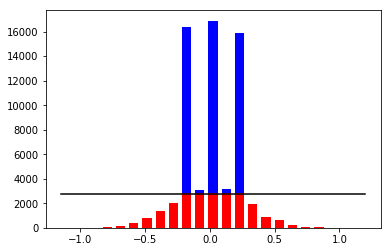

In [7]:
image_paths, labels = uniform_data(image_paths_ori, labels_ori, display_mode = True)
print("Total images shrink from {} to {} after uniform process".format(image_paths_ori.shape, image_paths.shape))

#### 1.3 Split the data

In [8]:
image_paths_train, image_paths_test, labels_train, labels_test = train_test_split(image_paths,
                                                                                  labels,
                                                                                  test_size=args['test_size'],
                                                                                  random_state=42)
print('Total:', image_paths.shape, labels.shape)
print('Training:', image_paths_train.shape, labels_train.shape)
print('Test:', image_paths_test.shape, labels_test.shape)

Total: (22943,) (22943,)
Training: (18354,) (18354,)
Test: (4589,) (4589,)


#### 1.4 (Just for Test) Select some data randomly for debugging

In [9]:
# Comment them when running the whole set of data
indices_train = np.random.randint(0, len(image_paths_train), 64)
indices_test = np.random.randint(0, len(image_paths_test), 16)
image_paths_train = image_paths_train[indices_train]
labels_train = labels_train[indices_train]
image_paths_test = image_paths_test[indices_test]
labels_test = labels_test[indices_test]

print('Training:', image_paths_train.shape, labels_train.shape)
print('Test:', image_paths_test.shape, labels_test.shape)

Training: (64,) (64,)
Test: (16,) (16,)


#### 1.5 Load images with generator

In [10]:
def generator(X_path, y, batch_size=64):
    """
    Object: define a generator to extract training data and test data
    
    Generators can be a great way to work with large amounts of data. Instead of storing 
    the preprocessed data in memory all at once, using a generator you can pull pieces of 
    the data and process them on the fly only when you need them, which is much more memory-efficient.
    
    A generator is like a coroutine, a process that can run separately from another main routine, 
    which makes it a useful Python function. Instead of using return, the generator uses yield, 
    which still returns the desired output values but saves the current values of all the generator's
    variables. When the generator is called a second time it re-starts right after the yield statement, 
    with all its variables set to the same values as before.
    """
    num_samples = len(X_path)    
    
    while True: # Loop forever so the generator never terminates
        
        X_path, y = shuffle(X_path, y)
        for offset in range(0, num_samples, int(batch_size/2)):
            # Half batch size is used, since images are flipped in the following codes
            X_path_sub = X_path[offset:offset + int(batch_size/2)]
            y_sub   = y[offset:offset + int(batch_size/2)]

            images = []
            for image_path in X_path_sub:
                image = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
                image_aug = cv2.flip(image,1)
                images.append(image)
                images.append(image_aug)
            labels = []
            for label in y_sub:
                labels.extend([float(label),float(label)*-1])

            X_batch = np.array(images,dtype='float64')
            y_batch = np.array(labels,dtype='float64')

            yield shuffle(X_batch, y_batch)

In [11]:
train_gen = generator(image_paths_train, labels_train, batch_size=args['batch_size'])
test_gen = generator(image_paths_test, labels_test, batch_size=args['batch_size'])

## Model

In [12]:
def build_model(args):
    """
    Function: Build a deep learning model
    Input:
        args: input parameters saved in the type of parser.parse_args
    Output:
    """
    if args['debug_mode'] is True:
        print("BUILDING MODEL......")
        
    model = Sequential()
    
    # Normalize
    model.add(Lambda(lambda x: x/255.0-0.5, input_shape=(160,320,3)))
    
    # Add a layer to crop images
    model.add(Cropping2D(cropping=((70,25), (0,0))))  # remaining size: 65,320,3
    
    # Add three 5x5 convolution layers
    model.add(Convolution2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Convolution2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Convolution2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    
    # Add two 3x3 convolution layers
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    
    # Add a flatten layer
    model.add(Flatten())
    
    # Add a dropout to overcome overfitting
    model.add(Dropout(args['keep_prob']))
    
    # Add three fully connected layers
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # Add a fully connected output layer
    model.add(Dense(1))
    
    # Summary
    model.summary()
    
    return model

In [13]:
model = build_model(args)

BUILDING MODEL......
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 33, 64)         

C:\Users\yipen\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2))`
C:\Users\yipen\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
C:\Users\yipen\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
C:\Users\yipen\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
C:\Users\yipen\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`


## Training

In [14]:
def train_model(model, args, train_gen, test_gen, image_paths_train, image_paths_test):
    """
    Function: train the model
    Input:
        model: built model 
        args: input parameters saved in the type of parser.parse_args
        data: traning and validation data
    Output:
    """
    if args['debug_mode'] is True:
        print("Training MODEL......")

    model.compile(loss='mse', optimizer='adam')
    
    model.fit_generator(train_gen,
                        validation_data=test_gen,
                        samples_per_epoch=len(image_paths_train)*2, # 2 for flip
                        nb_val_samples=len(image_paths_test)*2,  # 2 for flip
                        nb_epoch=args['nb_epoch'])
                        
    
    #checkpoint = ModelCheckpoint('model-{epoch:03d}.h5')
    model.save('model.h5')


In [15]:
train_model(model, args, train_gen, test_gen, image_paths_train, image_paths_test)
print("DONE!")

Training MODEL......


C:\Users\yipen\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\yipen\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=128, epochs=5, validation_data=<generator..., validation_steps=32)`


Epoch 1/5
128/128 [==============================] - 109s 854ms/step - loss: 0.0141 - val_loss: 0.0761
Epoch 2/5
128/128 [==============================] - 63s 491ms/step - loss: 0.0023 - val_loss: 0.0692
Epoch 3/5
128/128 [==============================] - 64s 496ms/step - loss: 0.0017 - val_loss: 0.0692
Epoch 4/5
128/128 [==============================] - 63s 488ms/step - loss: 0.0013 - val_loss: 0.0659
Epoch 5/5
128/128 [==============================] - 63s 490ms/step - loss: 0.0011 - val_loss: 0.0648
DONE!
